In [1]:
!pip install powerlaw
import powerlaw
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm, ks_2samp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#data= load_dataset("imdb", split= "test")
#data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data= load_dataset("poem_sentiment","plain_text", split = "test")
data = load_dataset("c4", "en", split= "train", streaming = True)


In [3]:
# For streaming data
data_head = data.take(1000)
df = pd.DataFrame(data_head)
# df = pd.DataFrame(data)

In [4]:
#for non-streaming data
#datadf = pd.json_normalize(data)

#### Looking at the top rows

In [5]:
df.head()

,timestamp,text,url
0,2019-04-25T12:57:54Z,Beginners BBQ Class Taking Place in Missoula!\...,https://klyq.com/beginners-bbq-class-taking-pl...
1,2019-04-21T10:07:13Z,Discussion in 'Mac OS X Lion (10.7)' started b...,https://forums.macrumors.com/threads/restore-f...
2,2019-04-25T10:40:23Z,Foil plaid lycra and spandex shortall with met...,https://awishcometrue.com/Catalogs/Clearance/T...
3,2019-04-21T12:46:19Z,How many backlinks per day for new site?\nDisc...,https://www.blackhatworld.com/seo/how-many-bac...
4,2019-04-20T14:33:21Z,The Denver Board of Education opened the 2017-...,http://bond.dpsk12.org/category/news/


#### Getting more information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10000 non-null  object
 1   text       10000 non-null  object
 2   url        10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


#### Checking for missing values

In [7]:
df[df.isnull().any(axis=1)].head()
np.sum(df.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [8]:
def count_vocab_frequencies(df):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of ALL words 
    (no stop word removal) and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    # Move this up as a constant in larger code.
    batch_size = 10
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    # Needed to modify the minimum token length: 
    # https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(df.text)
    document_matrix = cvec.transform(df.text)
    batches = np.linspace(0, df.shape[0], batch_size).astype(int)
    i = 0
    tf = []
    while i < len(batches) - 1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(), axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf, axis=0)], columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns = ['total']
    sorted_term_freq_df = pd.DataFrame(term_freq_df.sort_values(by='total', ascending=False)['total'])
    return sorted_term_freq_df

In [9]:
term_df = count_vocab_frequencies(df)
print("Info on the observed frequencies:")
print(term_df.info())
print("Observations look like this:")
print(term_df.head())

Info on the observed frequencies:
<class 'pandas.core.frame.DataFrame'>
Index: 100533 entries, the to 𐌼𐌿𐌽𐌳𐍃
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   total   100533 non-null  int64
dtypes: int64(1)
memory usage: 1.5+ MB
None
Observations look like this:
      total
the  186019
and  107893
to   103090
of    89417
a     81307


#### Fit the observations to a Zipfian powerlaw

In [10]:
# Uses the powerlaw package to fit the observed frequencies to a zipfian distribution

# Turn these into a probability distribution by normalizing by the total sum.
observed_counts = term_df['total'].values
norm = float(sum(observed_counts))
observed_frequencies = observed_counts/norm

# 'fit_method' is MLE by default; doesn't seem to change the results in my initial pokings.
# Also tried discrete_approximation="xmax"
fit = powerlaw.Fit(term_df['total'].values, fit_method="KS", discrete=True)
# The estimated values
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
distance = fit.power_law.KS()
# The predicted probability distribution
predicted_frequencies = fit.pdf()[0][::-1]/norm 
print("Optimal Alpha:\t\t%.4f" % alpha)
print("Optimal Rank cut-off:\t%s" % xmin)
print("Distance:\t\t%.4f" % distance)
# Significance testing
print("KS test:", end='\t\t')
print(ks_2samp(observed_frequencies, predicted_frequencies))

Calculating best minimal value for power law fit
Optimal Alpha:		1.6053
Optimal Rank cut-off:	2.0
Distance:		0.0146
KS test:		KstestResult(statistic=0.7000432592242531, pvalue=1.3538877480117501e-24)


<AxesSubplot:>

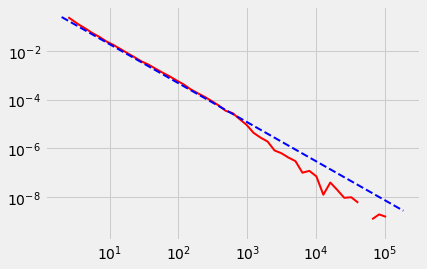

In [11]:
# Graph it out.
fig2 = fit.plot_pdf(color='r', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', linewidth=2, ax=fig2)

In [12]:
def plot_zipf(observed, predicted, alpha=1, multiplier=1):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    """
    num_tokens = len(predicted)
    y_pos = np.arange(num_tokens)
    plt.figure(figsize=(10,8))
    plt.bar(y_pos, observed[:num_tokens]*multiplier, align='center', alpha=0.5)
    plt.plot(y_pos, predicted*multiplier, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Frequency')
    plt.title("Top %s words in the dataset, with Zipf's law in dotted red" % num_tokens)


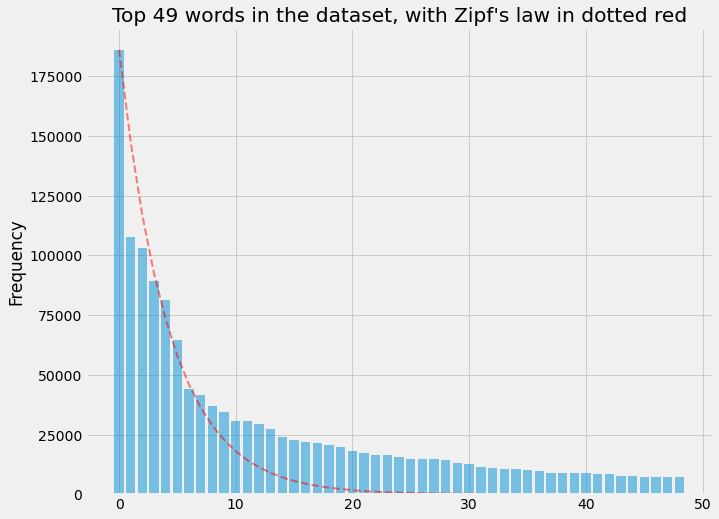

In [13]:
plot_zipf(observed_frequencies, predicted_frequencies, alpha=alpha, multiplier=norm)